https://github.com/spro/practical-pytorch/tree/master/char-rnn-classification

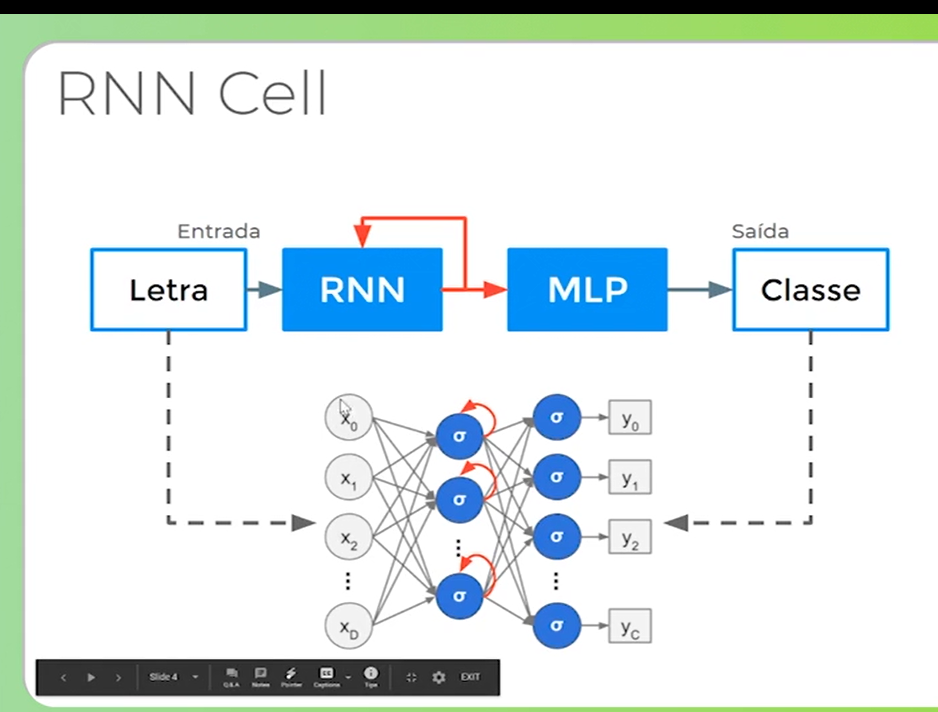

In [38]:
# Para os dados
import unicodedata
import string
import sys, random, os

# Para o processamento e análise
import torch
from torch import nn
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline

args = {
    'lr': 5e-5,
    'weight_decay': 1e-7,
    'regularizacao': 1e-7,
    'num_epocas': 40,
}
args['device'] = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("device:" + str(args['device']))

device:cuda


In [39]:
# comente as duas linhas seguintes caso rode mais de uma vez
!wget https://download.pytorch.org/tutorial/data.zip #
!unzip data.zip #
############################################################

--2022-07-14 20:16:53--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 52.84.251.115, 52.84.251.55, 52.84.251.49, ...
Connecting to download.pytorch.org (download.pytorch.org)|52.84.251.115|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip.2’

data.zip.2          100%[===================>]   2.75M  --.-KB/s    in 0.04s   

2022-07-14 20:16:53 (73.4 MB/s) - ‘data.zip.2’ saved [2882130/2882130]

Archive:  data.zip
replace data/eng-fra.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: data/eng-fra.txt        
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  

In [40]:
import os
import numpy as np
import unicodedata

# Transforma um arquivo de nomes em listas e/ou arrays (nomes, rotulos)
def readLines(path):
    nomes     = open(path).read().strip().split('\n')
    nomes     = [unicodedata.normalize('NFKD', nome).encode('ascii', 'ignore') for nome in nomes]
    categoria = path.split('/')[-1].split('.')[0]
    categorias = np.repeat(categoria, len(nomes))
    return nomes, categorias 


root_path = 'data/names/'
arquivos = sorted(os.listdir(root_path))

dados, rotulos = [], []
samples_perclass = []

for arquivo in arquivos:
  nomes, nacionalidades = readLines(os.path.join(root_path, arquivo))
  dados.append(nomes)
  rotulos.append(nacionalidades)

# visualizando dados
print(len(dados), len(rotulos))
print(len(dados[0]), len(rotulos[0]))
rotulos[0][0:10]

18 18
2000 2000


array(['Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic',
       'Arabic', 'Arabic', 'Arabic', 'Arabic'], dtype='<U6')

### Convertendo os rotulos para tensor

In [55]:
categorias = [arquivo.split('.')[0] for arquivo in arquivos]


def label2tensor(values, lista_idiomas):
  posicao = lista_idiomas.index(values)
  return torch.LongTensor([posicao])

rotulos[8][10], label2tensor(rotulos[8][10], categorias) 



('Irish', tensor([8]))

## Conversao dos dados para tensor

Representação one hot para codificar os nomes


In [42]:
import string

dicionario = string.ascii_letters + " '-"
dicionario

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ '-"

In [43]:
# abreu -> [1 0 0 0 .....]
def name2tensor(name):
  name_tensor = torch.zeros(len(name), len(dicionario))
  utf8_names_enum = []
  try:
    utf8_names_enum = enumerate(name.decode('utf-8'))
  except:
    utf8_names_enum = enumerate(name)
  for k, letra in utf8_names_enum:
    name_tensor[k][dicionario.index(letra)] = 1
  return name_tensor

# visualizar dados: representação one hot
dados[0][10], name2tensor(dados[0][10])


(b'Sabbagh',
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.

## Amostrando conjunto balanceado

In [44]:
np.random.choice(range(500), size=10)

array([425, 340,  83,  60, 118, 232, 463,  59, 352,  35])

In [68]:


def amostrar(num_amostras, lista_categorias):
  dados_amostra, rotulos_amostra = [], []

  for cat in lista_categorias:
    num_nomes = len(dados[categorias.index(cat)])

    indices = np.random.choice(range(num_nomes), size=num_amostras)
    dados_amostra.extend([dado for idx, dado in enumerate(dados[categorias.index(cat)]) if idx in indices ])
    rotulos_amostra.extend([rotulo for idx, rotulo in enumerate(rotulos[categorias.index(cat)]) if idx in indices ])

  dados_amostra = [name2tensor(nome) for nome in dados_amostra]
  rotulos_amostra = [name2tensor(rotulo) for rotulo in rotulos_amostra]
  return dados_amostra, rotulos_amostra

num_amostras = 50
dados_tensor, rotulos_tensor = amostrar(num_amostras, categorias)
print(len(dados_tensor), len(rotulos_tensor))
print(dados_tensor[10], rotulos_tensor[10])



794 794
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

NameError: ignored

## Modelo Recorrente

* Implemente um modelo para classificação de nomes próprios (série de caracteres) usando apenas camadas *RNNCell*, *Linear* e ativação *LogSoftmax*
* Cada entrada (caracter) possui dimensão (52): alfabeto maiúsculo e minúsculo
* *Hidden size* possui dimensão (256): hiperparâmetro 
* Saída possui dimensão (18): vetor de probabilidade de classes
* Batch size = 1 **pra não termos que lidar com as sequências de tamanho variável.**

### Links úteis

RNNCell: https://pytorch.org/docs/stable/generated/torch.nn.RNNCell.html#torch.nn.RNNCell

Linear: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear

Non-linear activations: https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html#torch.nn.LogSoftmax

In [47]:
from torch import nn

print(args['device'])


class RNN(nn.Module):

  def __init__(self, size_entrada, size_hidden, size_saida):
    super(RNN, self).__init__()
    self.size_hidden = size_hidden
    # hidden é o mesmo tamanho da memeoria, h
    self.recurrent = nn.RNNCell(size_entrada, size_hidden)
    self.saida = nn.Linear(size_hidden, size_saida)
    self.ativacao = nn.LogSoftmax()



  def forward(self, nome):
    # inicializar a memoria interna / feature/ hidden state / h
    # dim: B x F
    h = torch.zeros(1, self.size_hidden).to(args['device']) 

    # numero_letas x 55
    for letra in nome:
      ht = self.recurrent(letra.unsqueeze(0), h) # 1 x 55 -> B x N
    
    # retorna apenas o ultimo h
    saida = self.ativacao(self.saida(h))
    # retorna o vetor de 18 probabilidades
    return saida





cuda


In [48]:
hidden_layer = 256
modelo = RNN(len(dicionario), hidden_layer, len(categorias)).to(args['device'])
print(modelo)

RNN(
  (recurrent): RNNCell(55, 256)
  (saida): Linear(in_features=256, out_features=18, bias=True)
  (ativacao): LogSoftmax(dim=None)
)


## Loss e Otimizador

In [63]:
criterion = nn.NLLLoss().to(args['device'])
optimizer = torch.optim.Adam(modelo.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])



## Treinamento e teste

A otimização é um processo que tem uma raíz muito bem definida de passo a passo, sempre fazemos:
* Carregar os dados e colocar no dispositivo de hardware adequado
* Forward do dado na rede
* Cálculo da função de custo (no nosso caso uma função composta)
* Passos de Otimização
  * Zerar os gradientes do otimizador (`optimizer.zero_grad()`)
  * Calcular os gradientes com base na loss (`loss.backward()`)
  * Passo de otimização (`optimizer.step()`)

Apesar de cada solução ter pequenas variações em um ou mais passos do fluxo, o esqueleto é sempre o mesmo. 

In [64]:

def forward(X, Y, etapa):
  if etapa == 'Treino': modelo.train()
  else: modelo.eval()

  acuracia = 0.
  loss_epoca = []
  for k, (dado, rotulo) in enumerate(zip(X, Y)):
      
    dado = dado.to(args['device'])
    rotulo = rotulo.to(args['device'])

    saida = modelo(dado)
    loss = criterion(saida, rotulo)
    loss_epoca.append(loss.detach().cpu().numpy())

    _, pred = torch.max(saida, axis=-1)
    acuracia += 1 if pred[0].item() == rotulo[0].item() else 0

    if etapa == 'Treino':
      # Otimização
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

  loss_epoca = np.asarray(loss_epoca).ravel()
  acuracia   = acuracia/float(len(loss_epoca))
  print('\n','*'*15 + etapa + '*'*15 )
  print('Epoca: {:}, Loss: {:.4f} +/- {:.4f}, Acurácia: {:.4f}'.format(epoca, loss_epoca.mean(), 
                                                                        loss_epoca.std(), 
                                                                        acuracia
                                                                       )) 
  return loss_epoca.mean(), acuracia

In [59]:

loss_treino, loss_test = [], []
acc_treino, acc_test = [], []

dados_test, rotulos_test = amostrar(5, categorias)


In [67]:
loss_treino, loss_test = [], []
acc_treino, acc_test = [], []

dados_test, rotulos_test = amostrar(5, categorias)
for epoca in range(200):

  dados_tns, rotulos_tns = amostrar(5, categorias)

  #loss, acuracia = forward(dados_tns, rotulos_tns, 'Treino')
  #loss_treino.append(loss)
  #acc_treino.append(acuracia)  

  loss, acuracia = forward(dados_test, rotulos_test, 'Teste')
  loss_test.append(loss)
  acc_test.append(acuracia)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


ValueError: ignored

In [ ]:
class RNN(nn.Module):

  def __init__(self, tam_entrada, tam_feature, tam_saida):
    super(RNN, self).__init__()

    self.tam_entrada = tam_dicionario
    self.tam_feature = tam_feature 
    self.tam_saida = tam_saida

    # camadas *RNNCell*, *Linear* e ativação *LogSoftmax*
    self.rnn = nn.RNNCell(self.tam_entrada, self.tam_feature)
    self.linear = nn.Linear(self.tam_feature, self.tam_saida)
    self.softmax = nn.LogSoftmax()


  def forward(self, nome):

    # Inicializar o estado 
    hidden = torch.zeros(1, self.tam_feature).to(args['device'])

    for letra in nome:
      print(" - letra:" + str(len(letra)))
      letra = letra.unsqueeze(0)
      print(" - letra:" + str(len(letra)))
      hidden = self.rnn(letra, hidden)
    
    saida = self.linear(hidden)
    saida = self.softmax(saida)
    return saida



